**Objective of this notebook:**

1) To try out various state-of-the-art Transformer Based Vision Models:
   * SWIN Transfomer

2) To generate kaggle submission files for all the trained models

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!cp /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/dog-breed-identification.zip /content/

In [ ]:
!unzip dog-breed-identification.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil

import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score,classification_report

import cv2
import tensorflow as tf
from tensorflow.data import AUTOTUNE
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Conv2D,Dense,BatchNormalization,Flatten,Lambda, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

from prettytable import PrettyTable

In [ ]:
kaggle_file_dir = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/KaggleSubmission/"

In [ ]:
#read csv file having the training image 'file name' and its 'breed category'
train_df = pd.read_csv("/content/labels.csv")

#convert breed to numeric values
unique_breeds = list(pd.unique(train_df["breed"]))
unique_breeds_map = {breed:ind for ind,breed in enumerate(unique_breeds)}
unique_breeds_reversemap = {ind:breed for breed,ind in unique_breeds_map.items()}
train_df["breed_id"] = train_df["breed"].map(unique_breeds_map) 

In [ ]:
dir="train"
img_names = train_df["id"] + ".jpg"
height = []
width = []

for img in img_names:
  image = cv2.imread(os.path.join(dir,img))
  h,w,c = image.shape
  height.append(h)
  width.append(w)

train_df["height"] = height
train_df["width"] = width
train_df["aspect_ratio"] = train_df["height"] / train_df["width"]  

In [ ]:
train_df = train_df.loc[(train_df["aspect_ratio"] > 0.5) & (train_df["aspect_ratio"] < 2.3)]
train_df.shape

(10199, 6)

Collect the path, labels of training images

In [ ]:
train_dir = "train"
train_image_dir = os.path.join(os.getcwd(),train_dir)+os.sep
paths = train_image_dir + train_df["id"] + ".jpg"
labels = train_df["breed_id"].values
num_classes =  train_df["breed_id"].nunique()

Split the images between training and validation data

In [ ]:
val_percent = 0.2
train_percent = 1-val_percent
train_paths,val_paths, train_label,val_label = train_test_split(paths,labels,test_size=val_percent,stratify=labels)
train_size = train_paths.shape[0]
val_size = val_paths.shape[0]

Build input pipeline using the pathnames and labels

In [ ]:
resize_height = 350
resize_width  = 350
batch_size = 16

In [ ]:
def load_images_test(imagePath,istrain=True):

	image = tf.io.read_file(imagePath)
	image = tf.image.decode_jpeg(image, channels=3)
	
	image = tf.image.resize(image, [resize_height,resize_width])
	return image
	

In [ ]:
def load_images(imagePath,label,istrain=True):
	# read the image from disk, decode it and resize it
	image = tf.io.read_file(imagePath)
	image = tf.image.decode_jpeg(image, channels=3)
	image = tf.image.resize(image, [resize_height,resize_width])
	
	#Convert label into one hot encoding since we need to output probabilities for all classes
	label = tf.one_hot(tf.cast(label, tf.uint8), num_classes)
	return (image, label)

Data Augmentation using Keras Preprocessing Layers

https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
def configure_for_performance(ds,istrain=True,istest=False):
  if istrain:
    ds = ds.cache('/content/train_cache')  #since training data is huge, use disk space to cache the data
    ds = ds.shuffle(buffer_size=500)       #reduced buffer size to avoid out of memory errors

  elif istest:

    ds = ds.cache('/content/test_cache')     #use RAM memory to cache the validation data as it is relatively very small and disk space is getting exhausted
    #ds = ds.shuffle(buffer_size=100)
  
  else:
    ds = ds.cache('')     #use RAM memory to cache the validation data as it is relatively very small and disk space is getting exhausted
    ds = ds.shuffle(buffer_size=100)

  ds = ds.batch(batch_size)
  
  # Use data augmentation only on the training set.
  if istrain:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip(mode='horizontal'),
  layers.RandomRotation(0.2,fill_mode='constant'),
  layers.RandomZoom(0.1, 0.1,fill_mode='constant'),
  layers.RandomTranslation(0, 0.2)
])

###Optional Section to see how data augmentation techniques produces images

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_label))
train_ds = train_ds.shuffle(train_size).map(load_images,num_parallel_calls=AUTOTUNE)

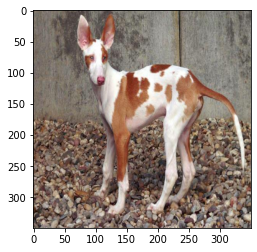

In [ ]:
image, label = next(iter(train_ds))
image = tf.cast(image,tf.float32)/255.0
_ = plt.imshow(image)
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

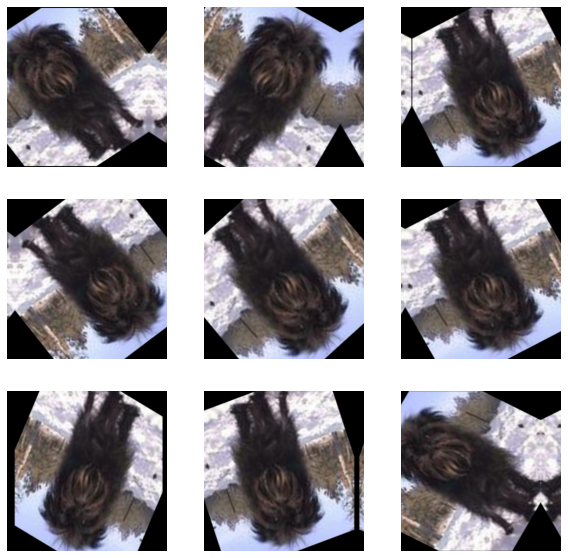

In [ ]:
#Check how the augmentation techniques work
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image,training=True)
  plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")
  

###Continue with Model Training

In [ ]:
#shutil.rmtree('train_cache')
os.makedirs("train_cache")

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_label))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_label))

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

8159
2040


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_label))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_label))

train_ds = train_ds.shuffle(train_size).map(load_images,num_parallel_calls=AUTOTUNE)
train_ds = configure_for_performance(train_ds,istrain=True,istest=False)

val_ds = val_ds.shuffle(val_size).map(load_images, num_parallel_calls=AUTOTUNE)
val_ds = configure_for_performance(val_ds,istrain=False,istest=False)

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

510
128


In [ ]:
for image, label in train_ds.take(1): #use 1 batch
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (16, 350, 350, 3)
Label:  (16, 120)


### Get input pipeline for the test directory

In [ ]:
#shutil.rmtree("test_cache")
os.makedirs("test_cache")

In [ ]:
test_paths = pd.DataFrame(os.listdir("test"),columns=["test_path"])
test_paths_l = [os.path.join("test",path) for path in test_paths["test_path"]]
test_ds = tf.data.Dataset.from_tensor_slices(test_paths_l)
test_ds = test_ds.map(load_images_test,num_parallel_calls=AUTOTUNE)
test_ds = configure_for_performance(test_ds,istrain=False,istest=True)

Process test predictions from model

In [ ]:
def process_test_pred(test_pred, csv_name="test_sub.csv"):
  # 1. Identify the class with the maximum probability

  #Convert one-hot vector to integer variable
  test_pred_label = np.argmax(test_pred, axis=1)
  test_pred_label_arr = test_pred_label
  test_paths["pred_breed_id"] = test_pred_label_arr
  #Convert integer variable to categorical variable
  test_paths["pred_breed"] =  test_paths["pred_breed_id"].map(unique_breeds_reversemap)

  # 2. Populate the probabilities for all classes to the dataframe
  out_cols = list(unique_breeds_reversemap.values())
  test_paths[out_cols] = test_pred

  # 3. Process files for kaggle submission format
  test_paths["test_path"] = test_paths["test_path"].str.split('.jpg').str[0]
  out_cols.sort()
  order_cols = ['test_path'] + out_cols
  test_sub = test_paths[order_cols]
  test_sub.rename(columns={"test_path":"id"},inplace=True)
  test_sub.to_csv(csv_name,index=False)

### Using pretrained SWIN models from tfswin package available in PyPi 

In [ ]:
!pip install -q tfswin

###Model#1: Using SWIN Transformer SwinTransformerBase224

Paper: "Swin Transformer: Hierarchical Vision Transformer using Shifted Windows”"

URL: https://arxiv.org/pdf/2103.14030.pdf


In [ ]:
from tfswin import SwinTransformerBase224, preprocess_input

In [ ]:
def build_model1(swintransformer):
  tf.keras.backend.clear_session()

  # prepare the image for the VGG model
  inputs = Input(shape=(resize_height, resize_width, 3))

  outputs = Lambda(preprocess_input)(inputs)
  outputs = swintransformer(outputs)
  outputs = Dense(num_classes, activation='softmax')(outputs)

  swin_model = Model(inputs=inputs, outputs=outputs)

  return swin_model

In [ ]:
#build the model
swintransformer = SwinTransformerBase224(include_top=False,pooling='avg')
swin_model1 = build_model1(swintransformer)

#set the layers of the resnet pretrained model as non-trainable
for layer in swin_model1.layers[2].layers:   #-7 #-4
  layer.trainable = False

#compile the model

swin_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
print(swin_model1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 350, 350, 3)       0         
                                                                 
 swin_base_224 (Functional)  (None, 1024)              86743224  
                                                                 
 dense (Dense)               (None, 120)               123000    
                                                                 
Total params: 86,866,224
Trainable params: 123,000
Non-trainable params: 86,743,224
_________________________________________________________________
None


In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_base224"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_base224"

removed directory '/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_base224'


In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_base224"
local_ckpt_path = os.path.join(checkpoint_dir, 'swin_base224.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_loss',mode='min', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'callbacks_swin_base224', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

earlystop      = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1,mode='min')

reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0,mode='min')
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
#Base SWIN
history = swin_model1.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
510/510 [==============================] - ETA: 0s - loss: 2.8779 - accuracy: 0.3650
Epoch 1: val_loss improved from inf to 0.82767, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_base224/swin_base224.h5
510/510 [==============================] - 600s 1s/step - loss: 2.8779 - accuracy: 0.3650 - val_loss: 0.8277 - val_accuracy: 0.7745 - lr: 0.0010
Epoch 2/50
510/510 [==============================] - ETA: 0s - loss: 1.4594 - accuracy: 0.6317
Epoch 2: val_loss improved from 0.82767 to 0.57263, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_base224/swin_base224.h5
510/510 [==============================] - 576s 1s/step - loss: 1.4594 - accuracy: 0.6317 - val_loss: 0.5726 - val_accuracy: 0.8304 - lr: 0.0010
Epoch 3/50
510/510 [==============================] - ETA: 0s - loss: 1.1404 - accuracy: 0.6909


Process Kaggle File Submission

In [ ]:
# use load_weights since only weights are saved during ModelCheckpoint
swin_model1.load_weights(local_ckpt_path)

In [ ]:
test_pred = swin_model1.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_swin_base224.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


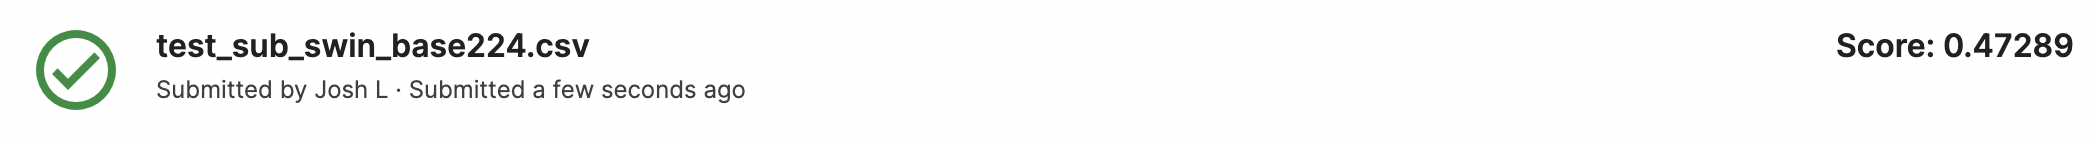

###Model#2: Using SWIN Transformer SwinTransformerBase384



In [ ]:
from tfswin import SwinTransformerBase384, preprocess_input

In [ ]:
#build the model
swintransformer = SwinTransformerBase384(include_top=False,pooling='avg')
swin_model2 = build_model1(swintransformer)

#set the layers of the resnet pretrained model as non-trainable
for layer in swin_model2.layers[2].layers:   #-7 #-4
  layer.trainable = False

#compile the model

swin_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
print(swin_model2.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 350, 350, 3)       0         
                                                                 
 swin_base_384 (Functional)  (None, 1024)              86878584  
                                                                 
 dense (Dense)               (None, 120)               123000    
                                                                 
Total params: 87,001,584
Trainable params: 123,000
Non-trainable params: 86,878,584
_________________________________________________________________
None


In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_base384"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_base384"

removed directory '/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_base384'


In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_base384"
local_ckpt_path = os.path.join(checkpoint_dir, 'swin_base384.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_loss',mode='min', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'callbacks_swin_base384', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

earlystop      = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1,mode='min')

reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=1, min_lr=0,mode='min')
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
#Base SWIN
history = swin_model2.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
510/510 [==============================] - ETA: 0s - loss: 1.6928 - accuracy: 0.6029
Epoch 1: val_loss improved from inf to 0.50671, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_base384/swin_base384.h5
510/510 [==============================] - 623s 1s/step - loss: 1.6928 - accuracy: 0.6029 - val_loss: 0.5067 - val_accuracy: 0.8422 - lr: 0.0010
Epoch 2/50
510/510 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.8059
Epoch 2: val_loss improved from 0.50671 to 0.43459, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_base384/swin_base384.h5
510/510 [==============================] - 587s 1s/step - loss: 0.6387 - accuracy: 0.8059 - val_loss: 0.4346 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 3/50
510/510 [==============================] - ETA: 0s - loss: 0.4936 - accuracy: 0.8477


Process Kaggle File Submission

In [ ]:
# use load_weights since only weights are saved during ModelCheckpoint
swin_model2.load_weights(local_ckpt_path)

In [ ]:
test_pred = swin_model2.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_swin_base384.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


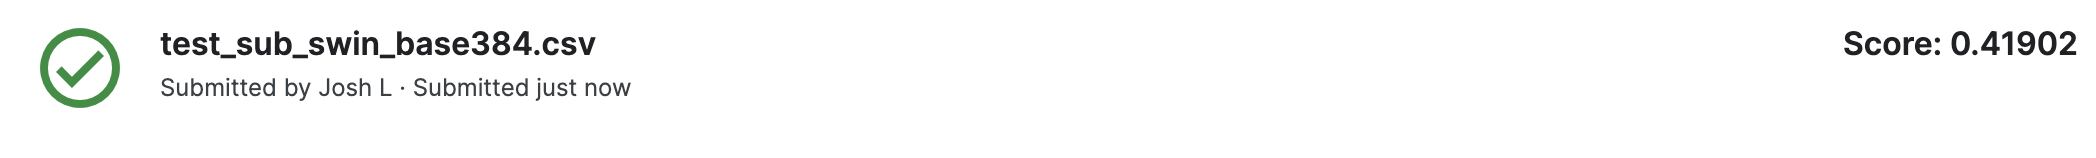

###Model#3: Using SWIN Transformer SwinTransformerLarge384



In [ ]:
from tfswin import SwinTransformerLarge384, preprocess_input

In [ ]:
#build the model
swintransformer = SwinTransformerLarge384(include_top=False,pooling='avg')
swin_model3 = build_model1(swintransformer)

#set the layers of the resnet pretrained model as non-trainable
for layer in swin_model3.layers[2].layers:   #-7 #-4
  layer.trainable = False

#compile the model

swin_model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
print(swin_model3.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 350, 350, 3)       0         
                                                                 
 swin_large_384 (Functional)  (None, 1536)             195198516 
                                                                 
 dense (Dense)               (None, 120)               184440    
                                                                 
Total params: 195,382,956
Trainable params: 184,440
Non-trainable params: 195,198,516
_________________________________________________________________
None


In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_large384"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_large384"

removed '/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_large384/swin_large384.h5'
removed directory '/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_large384'


In [ ]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_large384"
local_ckpt_path = os.path.join(checkpoint_dir, 'swin_large384.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_loss',mode='min', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'callbacks_swin_large384', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

earlystop      = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1,mode='min')

reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.8, cooldown=1, patience=1, min_lr=0,mode='min')
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
#Base SWIN
history = swin_model3.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
510/510 [==============================] - ETA: 0s - loss: 1.5490 - accuracy: 0.6611
Epoch 1: val_loss improved from inf to 0.36880, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_large384/swin_large384.h5
510/510 [==============================] - 1046s 2s/step - loss: 1.5490 - accuracy: 0.6611 - val_loss: 0.3688 - val_accuracy: 0.8892 - lr: 0.0010
Epoch 2/50
510/510 [==============================] - ETA: 0s - loss: 0.5054 - accuracy: 0.8527
Epoch 2: val_loss improved from 0.36880 to 0.25175, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_swin_large384/swin_large384.h5
510/510 [==============================] - 1032s 2s/step - loss: 0.5054 - accuracy: 0.8527 - val_loss: 0.2518 - val_accuracy: 0.9294 - lr: 0.0010
Epoch 3/50
510/510 [==============================] - ETA: 0s - loss: 0.3747 - accuracy: 0

Process Kaggle File Submission

In [ ]:
test_pred = swin_model3.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_swin_large384.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


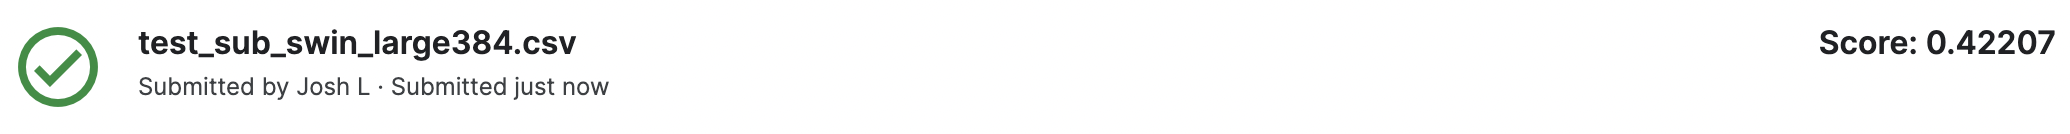

Summary of the results of all SWIN architectures

In [ ]:
modelTable = PrettyTable(["Model Name", "Training_Accuracy", "Validation_Accuracy", "Training_Loss","Validation_Loss"])
modelTable.add_row(["swin_base224",  "77.73%", "86.08%", "0.79", "0.47"])
modelTable.add_row(["swin_base384",  "92.14%", "87.45%", "0.27", "0.42"])
modelTable.add_row(["swin_large384",  "98.82%", "97.40%", "0.05", "0.11"])
print(modelTable)

+---------------+-------------------+---------------------+---------------+-----------------+
|   Model Name  | Training_Accuracy | Validation_Accuracy | Training_Loss | Validation_Loss |
+---------------+-------------------+---------------------+---------------+-----------------+
|  swin_base224 |       77.73%      |        86.08%       |      0.79     |       0.47      |
|  swin_base384 |       92.14%      |        87.45%       |      0.27     |       0.42      |
| swin_large384 |       98.82%      |        97.40%       |      0.05     |       0.11      |
+---------------+-------------------+---------------------+---------------+-----------------+


In [ ]:
kaggleTable = PrettyTable(["Model Name", "KaggleScore"])
kaggleTable.add_row(["swin_base224",  "0.47289"])
kaggleTable.add_row(["swin_base384",  "0.41902"])
kaggleTable.add_row(["swin_large384",  "0.42207"])
print(kaggleTable)

+---------------+-------------+
|   Model Name  | KaggleScore |
+---------------+-------------+
|  swin_base224 |   0.47289   |
|  swin_base384 |   0.41902   |
| swin_large384 |   0.42207   |
+---------------+-------------+


###**Conclusion:**

* None of the SWIN Transformer architecture is as good as single EfficientNet model. 
* Hence planning to use the ensemble of various EfficientNet architctures as the final model.